### Adversarial autoencoder

In this notebook, I train an adversarial autoencoder on the MNIST dataset of handwritten digits.

Much of the code is copied from similar examples online.

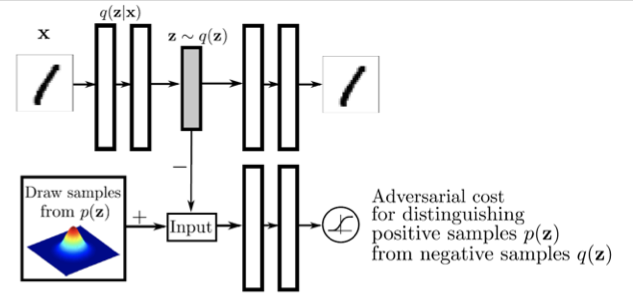

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## Prepare MNIST data

# Use both the training & test MNIST digits.
batch_size = 16
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_digits = all_digits[0:2000]
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)


In [3]:
home_dir = '/home/ec2-user/SageMaker/adversarial-autoencoder/keras-aae/'

In [4]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense
from keras.utils import plot_model
from keras.datasets import mnist
from keras.optimizers import Adam
import argparse
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
from datetime import datetime
from sklearn.manifold import TSNE
from absl import flags
from absl import app

def create_model(input_dim, latent_dim, adversarial=True, verbose=False, save_graph=False):

    autoencoder_input = Input(shape=(input_dim,))
    generator_input = Input(shape=(input_dim,))

    encoder = Sequential()
    encoder.add(Dense(1000, input_shape=(input_dim,), activation='relu'))
    encoder.add(Dense(1000, activation='relu'))
    encoder.add(Dense(latent_dim, activation=None))
    
    decoder = Sequential()
    decoder.add(Dense(1000, input_shape=(latent_dim,), activation='relu'))
    decoder.add(Dense(1000, activation='relu'))
    decoder.add(Dense(input_dim, activation='sigmoid'))

    if adversarial:
        discriminator = Sequential()
        discriminator.add(Dense(1000, input_shape=(latent_dim,), activation='relu'))
        discriminator.add(Dense(1000, activation='relu'))
        discriminator.add(Dense(1, activation='sigmoid'))

    autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
    autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error")
    
    if adversarial:
        discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
        discriminator.trainable = False
        generator = Model(generator_input, discriminator(encoder(generator_input)))
        generator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")

    if verbose:
        print("Autoencoder Architecture")
        print(autoencoder.summary())
        if adversarial:
            print("Discriminator Architecture")
            print(discriminator.summary())
            print("Generator Architecture")
            print(generator.summary())

    if save_graph:
        plot_model(autoencoder, to_file=home_dir + "autoencoder_graph.png")
        if adversarial:
            plot_model(discriminator, to_file=home_dir + "discriminator_graph.png")
            plot_model(generator, to_file=home_dir + "generator_graph.png")

    if adversarial:
        return autoencoder, discriminator, generator, encoder, decoder
    else:
        return autoencoder, None, None, encoder, decoder

def train(n_samples, batch_size, n_epochs, adversarial=True, latent_dim=2):
    autoencoder, discriminator, generator, encoder, decoder = create_model(input_dim=784, latent_dim=latent_dim)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Get n_samples/10 samples from each class
    x_classes = {}
    y_classes = {}
    for i in np.arange(10):
        x_classes[i] = x_train[np.where(y_train == i), :, :][0][:int(n_samples / 10), :, :]
        y_classes[i] = np.ones(int(n_samples / 10)) * i
    x = np.concatenate((list(x_classes.values())))
    y = np.concatenate((list(y_classes.values())))
    x = x.reshape(-1, 784)
    normalize = colors.Normalize(0., 255.)
    x = normalize(x)

    rand_x = np.random.RandomState(42)
    rand_y = np.random.RandomState(42)

    past = datetime.now()
    for epoch in np.arange(1, n_epochs + 1):
        autoencoder_losses = []
        if adversarial:
            discriminator_losses = []
            generator_losses = []
        rand_x.shuffle(x)
        rand_y.shuffle(y)
        for batch in np.arange(len(x) / batch_size):
            start = int(batch * batch_size)
            end = int(start + batch_size)
            samples = x[start:end]
            autoencoder_history = autoencoder.fit(x=samples, y=samples, epochs=1, batch_size=batch_size, validation_split=0.0, verbose=0)
            if adversarial:
                fake_latent = encoder.predict(samples)
                discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, latent_dim) * 5.))
                discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
                discriminator_history = discriminator.fit(x=discriminator_input, y=discriminator_labels, epochs=1, batch_size=batch_size, validation_split=0.0, verbose=0)
                generator_history = generator.fit(x=samples, y=np.ones((batch_size, 1)), epochs=1, batch_size=batch_size, validation_split=0.0, verbose=0)

            autoencoder_losses.append(autoencoder_history.history["loss"])
            if adversarial:
                discriminator_losses.append(discriminator_history.history["loss"])
                generator_losses.append(generator_history.history["loss"])
        now = datetime.now()
        print("\nEpoch {}/{} - {:.1f}s".format(epoch, n_epochs, (now - past).total_seconds()))
        print("Autoencoder Loss: {}".format(np.mean(autoencoder_losses)))
        if adversarial:
            print("Discriminator Loss: {}".format(np.mean(discriminator_losses)))
            print("Generator Loss: {}".format(np.mean(generator_losses)))
        past = now

        if epoch % 50 == 0:
            print("\nSaving models...")
            # autoencoder.save('{}_autoencoder.h5'.format(desc))
            encoder.save(home_dir + '{}_encoder.h5'.format(desc))
            decoder.save(home_dir + '{}_decoder.h5'.format(desc))
            # if FLAGS.adversarial:
            # discriminator.save('{}_discriminator.h5'.format(desc))
            # generator.save('{}_generator.h5'.format(desc))

    # autoencoder.save('{}_autoencoder.h5'.format(desc))
    encoder.save(home_dir + '{}_encoder.h5'.format(desc))
    decoder.save(home_dir + '{}_decoder.h5'.format(desc))
    # if FLAGS.adversarial:
        # discriminator.save('{}_discriminator.h5'.format(desc))
        # generator.save('{}_generator.h5'.format(desc))

def reconstruct(n_samples):
    encoder = load_model(home_dir + '{}_encoder.h5'.format(desc))
    decoder = load_model(home_dir + '{}_decoder.h5'.format(desc))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    choice = np.random.choice(np.arange(n_samples))
    original = x_test[choice].reshape(1, 784)
    normalize = colors.Normalize(0., 255.)
    original = normalize(original)
    latent = encoder.predict(original)
    reconstruction = decoder.predict(latent)
    draw([{"title": "Original", "image": original}, {"title": "Reconstruction", "image": reconstruction}])

def generate(latent=None, latent_dim=None):
    decoder = load_model(home_dir + '{}_decoder.h5'.format(desc))
    if latent is None:
        latent = np.random.randn(1, latent_dim)
    else:
        latent = np.array(latent)
    sample = decoder.predict(latent.reshape(1, latent_dim))
    draw([{"title": "Sample", "image": sample}])

def draw(samples):
    fig = plt.figure(figsize=(5 * len(samples), 5))
    gs = gridspec.GridSpec(1, len(samples))
    for i, sample in enumerate(samples):
        ax = plt.Subplot(fig, gs[i])
        ax.imshow((sample["image"] * 255.).reshape(28, 28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(sample["title"])
        fig.add_subplot(ax)
    plt.show(block=False)

def generate_grid(latent=None, latent_dim=2):
    decoder = load_model(home_dir + '{}_decoder.h5'.format(desc))
    samples = []
    for i in np.arange(400):
        latent = np.array([(i % 20) * 1.5 - 15., 15. - (i / 20) * 1.5])
        samples.append({
            "image": decoder.predict(latent.reshape(1, latent_dim))
        })
    draw_grid(samples)

def draw_grid(samples):
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(20, 20, wspace=-.5, hspace=0)
    for i, sample in enumerate(samples):
        ax = plt.Subplot(fig, gs[i])
        ax.imshow((sample["image"] * 255.).reshape(28, 28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        # ax.set_title(sample["title"])
        fig.add_subplot(ax)
    plt.show(block=False)
    # fig.savefig("images/{}_grid.png".format(desc), bbox_inches="tight", dpi=300)

def plot(n_samples, latent_dim):
    encoder = load_model(home_dir + '{}_encoder.h5'.format(desc))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x = x_test[:n_samples].reshape(n_samples, 784)
    y = y_test[:n_samples]
    normalize = colors.Normalize(0., 255.)
    x = normalize(x)
    latent = encoder.predict(x)
    if latent_dim > 2:
        tsne = TSNE()
        print("\nFitting t-SNE, this will take awhile...")
        latent = tsne.fit_transform(latent)
    fig, ax = plt.subplots()
    for label in np.arange(10):
        ax.scatter(latent[(y_test == label), 0], latent[(y_test == label), 1], label=label, s=3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_aspect('equal')
    ax.set_title("Latent Space")
    plt.show(block=False)
    # fig.savefig("images/{}_latent.png".format(desc), bbox_inches="tight", dpi=300)
    
    
def main(adversarial=True, train_bool=False, reconstruct_bool=False, generate_bool=False, generate_grid_bool=False,
         plot_bool=False, latent_dim=2, epochs=50, train_samples=10000, batchsize=100, latent_vec=None, 
         test_samples=10000):
    global desc
    if adversarial:
        desc = "aae"
    else:
        desc = "regular"
    if train_bool:
        train(n_samples=train_samples, batch_size=batchsize, n_epochs=epochs)
    elif reconstruct_bool:
        reconstruct(n_samples=test_samples)
    elif generate_bool:
        if latent_vec:
            assert len(latent_vec) == latent_dim, "Latent vector provided is of dim {}; required dim is {}".format(len(latent_vec), latent_dim)
            generate(latent_vec, latent_dim=latent_dim)
        else:
            generate(latent_dim=latent_dim)
    elif generate_grid_bool:
        generate_grid()
    elif plot_bool:
        plot(test_samples, latent_dim)




Using TensorFlow backend.


In [5]:
#main(generate_grid_bool=True)
main(train_bool=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Epoch 1/50 - 10.4s
Autoencoder Loss: 0.11074353456497192
Discriminator Loss: 0.2215978941693902
Generator Loss: 2.704229262173176

Epoch 2/50 - 7.9s
Autoencoder Loss: 0.06379593160003423
Discriminator Loss: 0.36973015643656254
Generator Loss: 1.6851338839530945

Epoch 3/50 - 8.3s
Autoencoder Loss: 0.058835052847862244
Discriminator Loss: 0.5214414176344871
Generator Loss: 0.9701623582839966

Epoch 4/50 - 7.8s
Autoencoder Loss: 0.05755460597574711
Discriminator Loss: 0.5498661416769027
Generator Loss: 0.9516031378507614

Epoch 5/50 - 7.7s
Autoencoder Loss: 0.058199794553220274
Discriminator Loss: 0.5993524643778801
Generator Loss: 0.9760773527622223

Epoch 6/50 - 7.8s
Autoencoder Loss: 0.059426697604358196
Discriminator Loss: 0.7150033155083656
Generator Loss: 0.8402405864000321

Epoch 7/50 - 7.8s
Autoencoder Loss: 0.05732438646256924
Discriminator Loss: 0.6980403205752372
Generator Loss: 0.7665259671211243

Epoch 8/50 - 7.8s
Autoencoder Loss: 0.0548002103343606
Discriminator Loss: 0.6

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


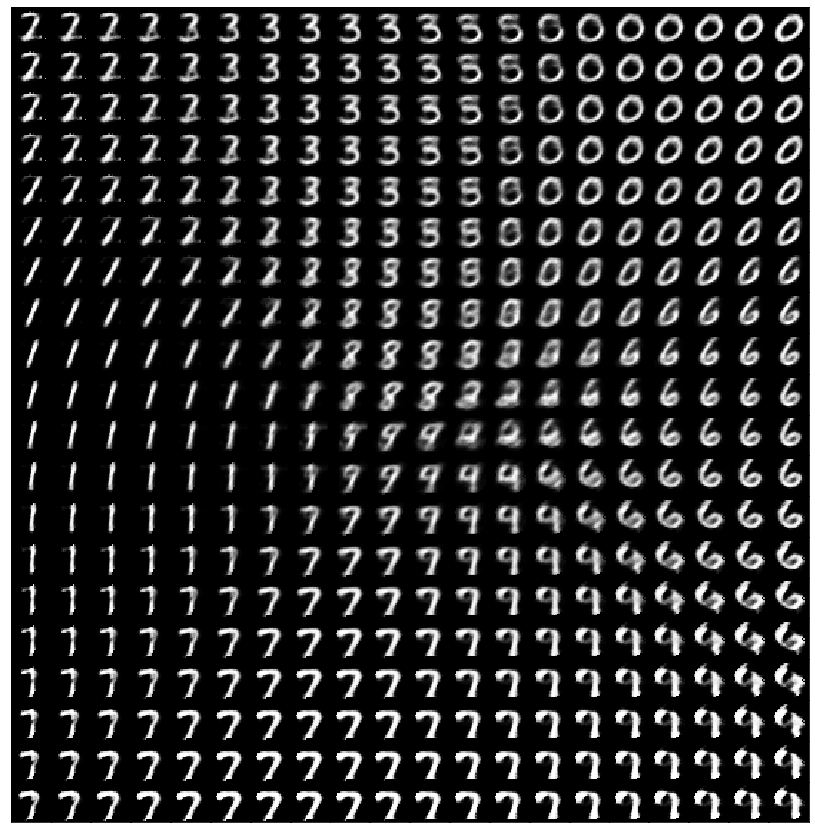

In [6]:
main(generate_grid_bool=True)

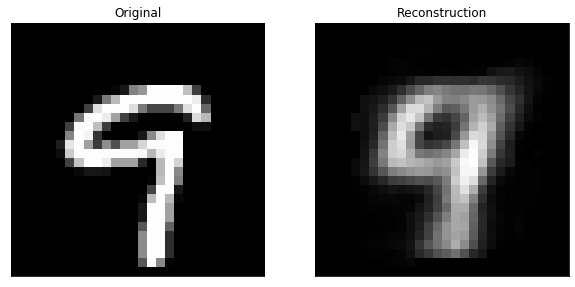

In [11]:
main(reconstruct_bool=True)